In [6]:
'''
Vi importerer nødvendige biblioteker
og definerer globale variabler med stinavne/filnavne 
'''
from PIL import Image
import csv
import os
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torch
import cv2
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torchvision import models as models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from numpy import argmax
from sklearn.model_selection import train_test_split

imagepath = 'C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/DatasætDeeplearning/license_plates_detection_train/'
csvpath = 'C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/DatasætDeeplearning/license_plates_detection_train.csv'
croppedImagesPath = 'C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/DatasætDeeplearning/croppedImages/'
trainingdatacsvpath = 'C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/trainingdata.csv'
predictioncsvpath = 'C:/Users/thoma/Documents/Softwareudvikling/Deep_learning/Eksamensprojekt/kode/DeepLearning/DatasætDeeplearning/license_plates_recognition_train.csv'
#test


#imagepath = 'C:/Users/chris/source/repos//DeepLearning/DatasætDeeplearning/license_plates_detection_train/'
#csvpath = 'C:/Users//chris//source/repos//DeepLearning/DatasætDeeplearning/license_plates_detection_train.csv'
#croppedImagesPath = 'C:/Users//chris//source/repos//DeepLearning/DatasætDeeplearning/croppedImages/'
#trainingdatacsvpath = 'C:/Users/chris/source/repos//DeepLearning/DatasætDeeplearning/trainingdata.csv'
#predictioncsvpath = 'C:/Users//chris/source/repos//DeepLearning/DatasætDeeplearning/license_plates_recognition_train.csv'


In [7]:
'''
DEL 1 - HELPER
Vi definerer en klasse med billededata,
som vi kan definere nye obkejter af
'''
class ImageData:
    def __init__(self, path, ymin, xmin, ymax, xmax):
        self.path = path
        self.xmin = xmin      
        self.ymin = ymin        
        self.xmax = xmax        
        self.ymax = ymax

In [8]:
'''
DEL 1 - HELPER
En funktion som læser data fra .CSV fil, 
og opretter nye billededata objekter af denne data
(.CSV filen indeholder data om, hvor nummerpladen sidder (XY-koordinater))
'''
def read_image_data():
    file = open(csvpath)
    csvreader = csv.reader(file)
    rows = []
    next(csvreader)
    for row in csvreader:
            imgdt = ImageData(row[0], int(row[1]), int(row[2]), int(row[3]), int(row[4]))
            rows.append(imgdt)
    file.close()
    return rows


In [9]:
'''
DEL 1 - OPGAVE 1
En funktion som læser billederne ind, 
og klipper nummerpladen ud,
hvorefter de nye billeder gemmes i en ny mappe (croppedImages)
'''
def crop_images():
    imageData = read_image_data()

    for id in imageData:
        im = Image.open(imagepath + id.path)
        im = im.crop( (id.xmin, id.ymin, id.xmax, id.ymax) )
        im.save(croppedImagesPath + id.path) 
        im.close()

os.makedirs(croppedImagesPath, exist_ok=True)

crop_images()

In [10]:
'''
DEL 1 - OPGAVE 2 
Vi definerer en klasse,
som kun indeholder billedets navn (filnavn) og nummerpladen (string)
'''
class PredictionData:
    def __init__(self, path, licenseplate):
        self.path = path
        self.licenseplate = licenseplate

In [11]:
'''
DEL 1 - HELPER 
En funktion som læser data fra .CSV filen,
og opretter nye objekter af PredictionData
'''
def read_prediction_data():
    file = open(predictioncsvpath)
    csvreader = csv.reader(file)
    rows = []
    next(csvreader)
    for row in csvreader:
            pd = PredictionData(row[0], row[1])
            rows.append(pd)
    file.close()
    return rows


In [35]:
'''
DEL 1 - OPGAVE 2 
En funktion som laver vores data om til one-hot-encoding, som gemmes i en ny .CSV fil.
Vi behandler vores data, hvor one-hot-encoding deler vores data op i kategorier, 
som vores Deep learning algortime kan forstå.
'''
def onehot_encoding():
    predictiondata = read_prediction_data()
    numbers = '0123456789'
    onehot_encoded = list()
    header = ['img_id', 'text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    with open(trainingdatacsvpath, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)

        for data in predictiondata:
            # Vi fjerner T and N fra nummerpladen
            datatrimmed = data.licenseplate.replace('T', '')
            datatrimmed = datatrimmed.replace('N', '')

            # Vi laver nummerpladen om til en liste af nummerene fra nummerpladen
            char_to_int = dict((c, i) for i, c in enumerate(numbers))
            integer_encoded = [char_to_int[char] for char in datatrimmed] 
            #print(integer_encoded)

            # Vi laver nu one-hot-encode
            # 1 bliver sat, hvis det eksisterer i nummerpladen
            letter = [0 for _ in range(len(numbers))]
            for value in integer_encoded:
                letter[value] = 1
            
            # Billedets navn og den oprindelige nummerplade indsættes også i vores .CSV fil
            letter.insert(0, data.path)
            letter.insert(1, data.licenseplate)
            
            writer.writerow(letter)
            onehot_encoded.append(letter)

onehot_encoding() 
    

In [13]:
'''
DEL 1 - OPGAVE 3 
Vi opdeler i et training set og et validation set,
hvor vi angiver et seed, hvilket sikre at samme datasæt generes ved samme seed
'''
with open(trainingdatacsvpath) as trainingcsv:
    next(trainingcsv)
    file_read = csv.reader(trainingcsv)
    array = list(file_read)

train, test = train_test_split(array,test_size=0.25,random_state=10) #Det unikke seed nummer er 10
header = ['img_id', 'text', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Vi tilføjer headers til vores data, tilføjer den til to nye .CSV filer
pd.DataFrame(test).to_csv("test.csv",header=header,index=False)
pd.DataFrame(train).to_csv("train.csv",header=header,index=False)


In [36]:
'''
DEL 1 - OPGAVE 4 
Vi laver en funktion, som kan visualisere vores data.
Der printes: 
    - shape (rækker, koloner)
    - head (de første 5 rækker)
    - tail (de sidste 5 rækker)
'''
def show_data_from_csv(csv_filepath: str):
    csv_data = pd.read_csv("test.csv")
    print("CSV shape:", csv_data.shape) 
    print("CSV head:")
    print(csv_data.head()) #det samme som csv_data[:5]
    print("CSV tail:")
    print(csv_data.tail()) #det samme som csv_data[-5:]

show_data_from_csv("test.csv") #"train.csv"


CSV shape: (225, 12)
CSV head:
    img_id      text  0  1  2  3  4  5  6  7  8  9
0  498.jpg  148T4932  0  1  1  1  1  0  0  0  1  1
1  217.jpg  174T4999  0  1  0  0  1  0  0  1  0  1
2  677.jpg  130T2637  1  1  1  1  0  0  1  1  0  0
3  276.jpg  148T2903  1  1  1  1  1  0  0  0  1  1
4  307.jpg  141T6603  1  1  0  1  1  0  1  0  0  0
CSV tail:
      img_id      text  0  1  2  3  4  5  6  7  8  9
220  175.jpg  175T7944  0  1  0  0  1  1  0  1  0  1
221  832.jpg   105T294  1  1  1  0  1  1  0  0  0  1
222  703.jpg   89T4187  0  1  0  0  1  0  0  1  1  1
223  764.jpg  156T4000  1  1  0  0  1  1  1  0  0  0
224  395.jpg  189T8840  1  1  0  0  1  0  0  0  1  1


In [15]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(25),
    transforms.CenterCrop(25),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 
                         std=[0.229, 0.224, 0.225] ) # Standard afvigelsen
    ])

imagenet_data = torchvision.datasets.ImageFolder(root="DatasætDeeplearning/",transform=TRANSFORM_IMG)

trainloader = torch.utils.data.DataLoader(imagenet_data, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(test, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('img_id', 'text' ,'0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')


In [16]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel: #Der er kun en kanal
        img = img.mean(dim=0)
    img = img / 2 + 0.5  #unnormalize, for at få den tilbage til den oprindelige til det neurale netværk (der kan godt udkommenteres)
    npimg = img.numpy()
    if one_channel: #Hvis der kun er en kanal blier det grå billeder 
        plt.imshow(npimg, cmap="Greys")
    else: #Hvis der er flere kanaler bliver det favet billeder 
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=144, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)#linear layer som har input features 84 og output feature 10. 

        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))#max pooling med en pooling shape på 2x2 over det første 2D convolutional layer
        x = self.pool(F.relu(self.conv2(x)))#max pooling med en pooling shape på 2x2 over det andet 2D convolutional layer
        x = x.view(-1, 9 * 4 * 4) #Ændrer formen på tensors.
        x = F.relu(self.fc1(x))#Linear layer bliver aktiveret via activation function 
        x = F.relu(self.fc2(x))#Linear layer bliver aktiveret via activation function 
        x = self.fc3(x)
        return x


model = Model()

In [18]:
criterion = nn.CrossEntropyLoss() #Bliver brugt til classification Logits --> softmax --> out probabilities opdeling i classes
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

In [19]:
writer = SummaryWriter('runs/numberplate_experiment_1') 

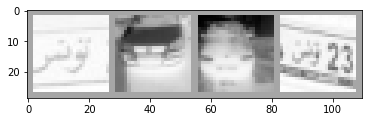

In [20]:
# get some random training images
dataiter = iter(trainloader) #Opretter en iterator, hvor den tager trainloader som parameter
images, labels = next(iter(trainloader))

writer.add_graph(model, images) #Tilføjer grafdata, tager imode vores model (net) og modeldata (images), som pararmetre

# create grid of images
img_grid = torchvision.utils.make_grid(images) #Laver et grid af vores billeder iform af et tensor

# show images
matplotlib_imshow(img_grid, one_channel=True) #Kalder vores funktion, som vi har defineret højere oppe i koden

# write to tensorboard
writer.add_image('numberplate_images', img_grid) #Data tilføjes til vores tensorborad
writer.close()

In [21]:
# helper functions

def images_to_probs(net, images): 
    '''
    Genererer forudsigelser og tilsvarende sandsynligheder fra en trænet
     netværk og en liste over billeder
    '''
    output = net(images)
    # konvertere output sandsynligheder til forudsagt klasse
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) #Fjerner enkeltdimensionelle indgange fra formen af et array
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]
    # softmax konverterer en vektor af tal til en vektor af sandsynligheder, hvor sandsynligheden for hver værdi er proportional med den relative skala af hver værdi i vektoren. 
    #Zip()-funktionen tager iterables (kan være nul eller flere), samler dem i en tupel og returnerer den


def plot_classes_preds(net, images, labels):
    '''
    Genererer matplotlib-figur ved hjælp af et trænet netværk sammen med billeder
     og etiketter fra en batch, der viser netværkets bedste forudsigelse
     med dens sandsynlighed, sammen med den faktiske etiket, farve denne
     information baseret på, om forudsigelsen var korrekt eller ej.
     Bruger funktionen "images_to_probs".
    '''
    preds, probs = images_to_probs(net, images)
    # plot billederne i batchen sammen med forudsagte og sande etiketter
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
                    #Den sammenligner sandsynligheden med billederne og labels 
                    #grøn jo mere sandsynlig den er og rød hvis den er mindre sandsynlig kan ses når vi køre koden

    return fig

In [41]:
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}  --host localhost

#%load_ext tensorboard
#%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16132), started 1 day, 0:48:23 ago. (Use '!kill 16132' to kill it.)

In [23]:
running_loss = 0.0
for epoch in range(1):  # looper over dataset 1 gang

    for i, data in enumerate(trainloader, 0): #looper igennem data fra vores trainloader

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #inputs og labels er tensors

        # zero the parameter gradients
        optimizer.zero_grad() #Vores gradient bliver resat (sættes til 0)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels) #Forward -> beregner output tensors ved brug af input tensors
        loss.backward() #Beregner gradienten udfra output tensors
        optimizer.step() #Optimizeren itererer over parametrene/vores tensors og opdaterer deres gradient 

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            #Tilføjer scalar data til vores tensorboard
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training
